<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment</b>
    
Hi  Steven, my name is Svetlana (https://hub.tripleten.com/u/6dee602c). Congratulations on submitting another project! 🎉
    

Before we start, I want to pay your attention to the color marking:
    

<div style="border: 5px solid green; padding: 15px; margin: 5px">

Great solutions and ideas that can and should be used in the future are in green comments. Some of them are: 
    
    
- You have successfully prepared the subsets. It is important to split the data correctly in order to ensure there's no intersection;    
    

- Excluded irrelevant columns; 


- Employed Optuna to tune hyperparameters, excellent! We tune them to identify the hyperparameters that will yield the desired metric value, so it's indeed very important;


- Analyzed metrics. It is not enough to just fit the model and print the result. Instead, we have to analyze the results as it helps us identify what can be improved;

    
    
- Wrote an excellent conclusion! A well-written conclusion shows how the project met its objectives and provides a concise and understandable summary for those who may not have been involved in the details of the project. Good job! 

</div>
    
<div style="border: 5px solid gold; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

Yellow color indicates what should be optimized. This is not necessary, but it will be great if you make changes to this project. I've left several recommendations throughout the project. Please take a look.
 
</div>
<div style="border: 5px solid red; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

Issues that must be corrected to achieve accurate results are indicated in red comments. Please note that the project cannot be accepted until these issues are resolved. More specifically:


- Let's add some basic EDA to make the project stronger. Would you please explore at least a couple of columns? What do their distributions look like?


- Please check the data for the duplicates without the columns you drop. Excluding columns may make previously distinct rows similar;     

    

    
- We have to use at least 2 class imbalance handling techniques. Would you add at least one more?
    

    

There may be other issues that need your attention. I described everything in my comments.  
</div>        
<hr>
    
<font color='dodgerblue'>**To sum up:**</font> you did a great job here, thank you so much! Actually the project is almost perfect, and the updates should not take much time. If you have any questions, please feel free to ask. I will wait the project for the second review 😊 
    

<hr>
    
Please use some color other than those listed to highlight answers to my comments.
I would also ask you **not to change, move or delete my comments** to make it easier for me to navigate during the next review.
    
<hr> 
    
✍️ Here's a link to [Supervised Learning documenation sections](https://scikit-learn.org/stable/supervised_learning.html) that you may find useful. I also want to recommend [Class Imbalance Strategies — A Visual Guide with Code](https://medium.com/towards-data-science/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a) article.
    
<hr>
    
📌 Please feel free to schedule a 1:1 sessions with our tutors or TAs [here](https://calendly.com/tripleten-ds-experts-team), join daily coworking sessions, or ask questions on TripleTen Hub if you need assistance 😉 
</div>

## Introduction

The purpose of this project is to predict, based on customer behavior and account properties, whether a customer will leave the bank. The effectiveness of the predictions will be measured through the F1 score, which is a way of measuring the ability to correctly predict the exact number of customers that exited. I've chosen CatBoost as the model for its ability to work with both numeric and categorical features, as well as its built-in ability to fix class imbalance through two different methods. I'll first optimize a model with the original class balance. I'll then optimize a 2nd model where the two CatBoost class-weighting options are available as parameters. I'll then select the model with the best F1 score in order to evaluate it on the test set. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

import site
site.addsitedir(site.getusersitepackages())
import optuna, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTENC

In [2]:
def custom_info(df, head_cnt=10):
    df.info(memory_usage=False)
    print("\n")
    display(df.head(head_cnt))

In [3]:
all_data = pd.read_csv("Churn.csv")
custom_info(all_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
# Inspect range and unique value count of each column
for col in all_data.columns:
    col_min = all_data[col].min()
    col_max = all_data[col].max()
    unq_val = all_data[col].nunique()
    print(f"{col}: {col_min} to {col_max} with {unq_val} unique values")
    
# Inspect the target class-balance
print(f"\n{all_data['Exited'].value_counts()}")    

RowNumber: 1 to 10000 with 10000 unique values
CustomerId: 15565701 to 15815690 with 10000 unique values
Surname: Abazu to Zuyeva with 2932 unique values
CreditScore: 350 to 850 with 460 unique values
Geography: France to Spain with 3 unique values
Gender: Female to Male with 2 unique values
Age: 18 to 92 with 70 unique values
Tenure: 0.0 to 10.0 with 11 unique values
Balance: 0.0 to 250898.09 with 6382 unique values
NumOfProducts: 1 to 4 with 4 unique values
HasCrCard: 0 to 1 with 2 unique values
IsActiveMember: 0 to 1 with 2 unique values
EstimatedSalary: 11.58 to 199992.48 with 9999 unique values
Exited: 0 to 1 with 2 unique values

0    7963
1    2037
Name: Exited, dtype: int64


About 20% of the targets is a customer that exited. When it comes to training the model, I don't see a use for RowNumber, CustomerId, and Surname. I'll drop those when creating the DF composed of the features. I'll create categorical versions of "Tenure" and "NumOfProducts" in order to provide the model with feature variations that do not assume a relevance to the numerical order. 

Tasks:

- Duplicate row check.
- Convert "Geography" and "Gender" to categorical.
- Create additional feature where "Tenure" is categorical and missing values are converted to an "unknown" category.
- Create additional "NumOfProducts" feature that's categorical.
- Look into that 11.58 "EstimatedSalary" value. Are there other salaries close to it?

In [5]:
# Check for duplicates

# Columns to ignore. EstimatedSalary also excluded since it contains 9,999 unique values
ignore_cols = ['RowNumber', 'CustomerId', 'Surname', 'EstimatedSalary']

# Columns to consider
check_cols = [c for c in all_data.columns if c not in ignore_cols]

# Duplicate rows
duplicates = all_data.duplicated(subset=check_cols, keep=False)

# Duplicate count
print("Potential Duplicate Count:", duplicates.sum())

# Display duplicates rows
duplicate_rows = all_data[duplicates]
display(duplicate_rows)

Potential Duplicate Count: 2


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2758,2759,15668347,Ingram,624,France,Male,36,6.0,0.0,2,0,0,84635.64,0
8857,8858,15810826,Chiekwugo,624,France,Male,36,6.0,0.0,2,0,0,84749.96,0


Even though this comes up as a duplicate when ignoring EstimatedSalary, I'm going to leave it in the data since I have no way of confirming it's actually a duplicate. In a real world scenario I could present it to the data provider as something of interest, especially considering the salary values are close to each other.  

In [6]:
# Categorical version of "Tenure"
all_data['TenureCAT'] = all_data['Tenure'].apply(
    lambda x: 'unknown' if pd.isna(x) else str(int(x))).astype('category')

all_data['Geography'] = all_data['Geography'].astype('category')
all_data['Gender'] = all_data['Gender'].astype('category')
all_data['NumOfProductsCAT'] = all_data['NumOfProducts'].astype('category')

# Store list of categorical features for CatBoost
cat_feat = ['Geography', 'Gender', 'TenureCAT', 'NumOfProductsCAT']

<div style="border: 5px solid red; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
- Before we move on to the machine learning models, let's display some charts to evaluate the distributions of different columns we have. For instance, do `Age`, `Salary` or other columns look normal? Do they have any outliers? 
    
 
 
- Conclusions are also important, so don't forget to leave a comment about each chart :)
    
</div>

<div style="border: 5px solid blue; padding: 10px; margin: 5px">
<b>Student's reply</b>
    
Below I check out the KDE of 3 columns
</div>

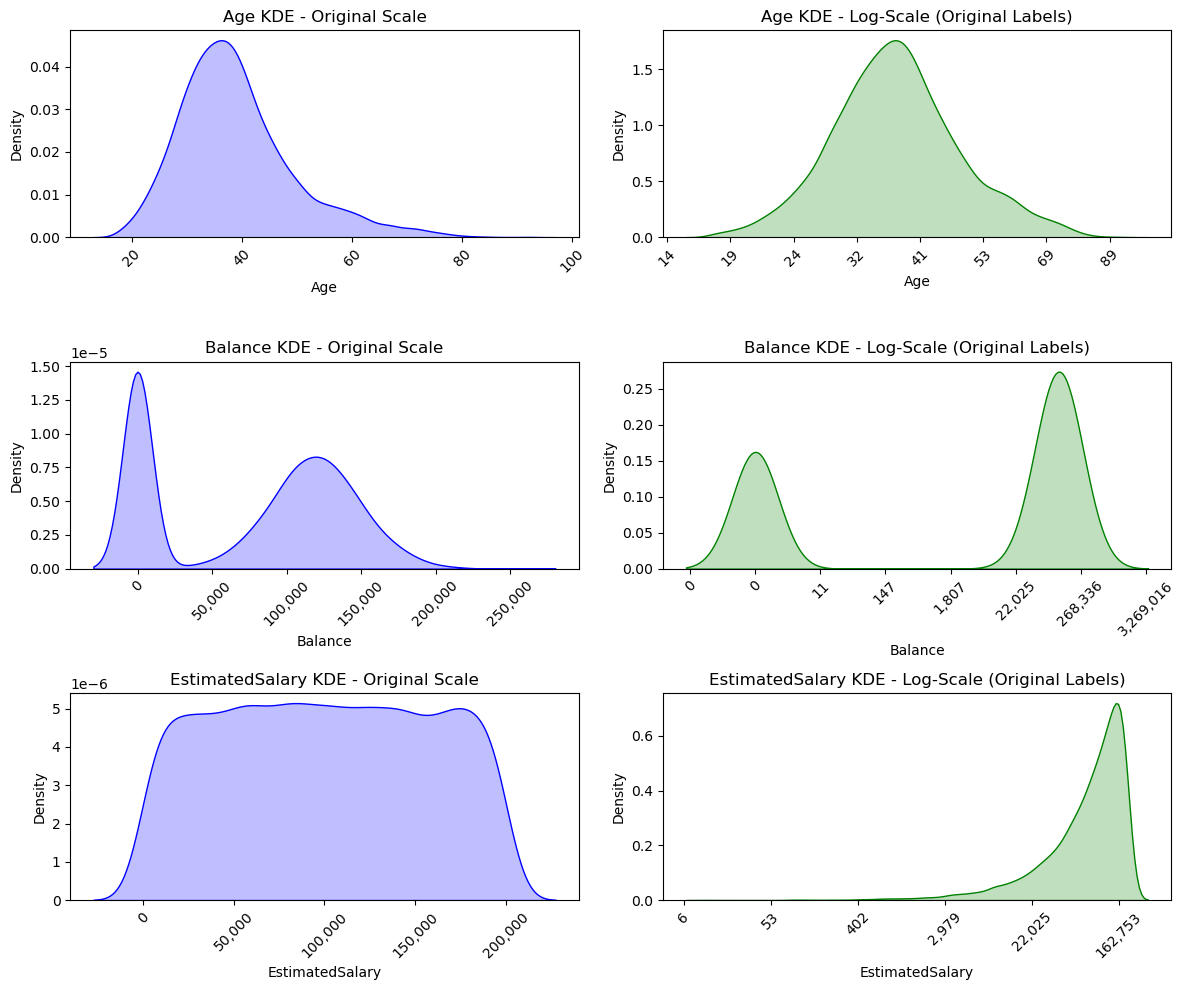

In [7]:
# KDE of "Age", "Balance", and "EstimatedSalary"

cols = ["Age", "Balance", "EstimatedSalary"]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, col in enumerate(cols):
    data = all_data[col].dropna()
    log_vals = np.log1p(data)
    
    # Left plot: Original scale KDE
    sns.kdeplot(data, fill=True, ax=axes[i, 0], color="blue")
    axes[i, 0].set_title(f"{col} KDE - Original Scale")
    axes[i, 0].set_xlabel(col)
    
    # Comma formatting and label rotation for original scale plots
    axes[i, 0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    # Right plot: Log-scaled KDE
    sns.kdeplot(log_vals, fill=True, ax=axes[i, 1], color="green")
    axes[i, 1].set_title(f"{col} KDE - Log-Scale (Original Labels)")
    axes[i, 1].set_xlabel(col)
    
    # Comma formatting and label rotation for log-scaled plots
    # In addition, use the original scale for the labels
    axes[i, 1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(np.expm1(x)):,}"))
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The two things that stood out is the large amount of 0 values in 'Balance' and the significant change in shape when viewing the KDE of EstimatedSalary through a log scale. Does such a dramatic change in shape indicate a model may potentially benefit from a feature variation where the values are converted to this scale? I'll try it out. 

In [8]:
# Look into the large amount of 0 values in 'Balance'
display(all_data[['Balance']].value_counts().sort_index().head(10))

# Look into the 11.58 minimum 'EstimatedSalary' revealed in the range check
display(all_data[['EstimatedSalary']].sort_values('EstimatedSalary', ascending=True).head(10))

Balance 
0.00        3617
3768.69        1
12459.19       1
14262.80       1
16893.59       1
23503.31       1
24043.45       1
27288.43       1
27517.15       1
27755.97       1
dtype: int64

,EstimatedSalary
2362,11.58
9647,90.07
9010,91.75
5548,96.27
4989,106.67
7565,123.07
2498,142.81
8722,143.34
4774,178.19
1451,216.27


There are many 'Balance' values of 0. Because of this, I'd like to see whether the model would benefit from a binary feature that specifies 'Is_Balance_0'.

The 11.58 minimum 'EstimatedSalary' value is quite low, but is it low enough to warrant some action? I don't know, so I'll leave it at that. 

In [9]:
# Binary feature variation of 'Balance': 'Is_Balance_0' (1 if True)
all_data['Is_Balance_0'] = (all_data['Balance'] == 0).astype(int)

# Log scaled feature variation of 'EstimatedSalary'
all_data['EstimatedSalaryLOG'] = np.log(all_data['EstimatedSalary'].astype(float))

### Training, Validation, and Test Set Creation

In [10]:
# Set up training, validation, and test set
RND = 12345

X = all_data.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
y = all_data['Exited'].copy()

# First divide into training/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RND
)

# Divide training set into training/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=RND
) # The result is a 60/20/20 set

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Class Count:", np.bincount(y_train), np.bincount(y_val), np.bincount(y_test))

Shapes: (6000, 14) (2000, 14) (2000, 14)
Class Count: [4777 1223] [1593  407] [1593  407]


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Yes, we can drop these columns, since they do not influence the behavior. 
</div>
<div style="border: 5px solid red; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    
Consider checking for the duplicates after you drop them. When we delete a column, previously distinct rows may become duplicated. However, when checking for the duplicates, we have to include the `Exited` column. Therefore, I recommend deleting `'RowNumber', 'CustomerId', 'Surname'` from `all_data` first, then checking for the duplicates and then creating target and features variables. 

</div>

<div style="border: 5px solid blue; padding: 10px; margin: 5px">
<b> Student's reply </b>

I decided to carry out the duplicate check before the distribution analysis so that in case there are duplicates I remove, the analysis won't be affected by them. Since the unique value count already revealed 'EstimatedSalary' has 9,999 unique values, this automatically means there can be at most 1 duplication if one considers 'EstimatedSalary'. Because of this, I decided to also exclude it in order to see if there were other similar rows of interest.
    
</div>    

## 1. Model Optimization (Untouched Class Balance)

In [11]:
N_TRIALS = 15 # Each trial trains a CatBoost model
# Find the best threshold for each candidate
thresholds = np.linspace(0.0, 0.75, 76)

def objective(trial):
    # Parameters to optimize
    depth = trial.suggest_int("depth", 3, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    iterations = trial.suggest_int("iterations", 2000, 3000)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 0.000001, 0.01, log=True)

    # Build CatBoost model with current parameters
    model = CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
        random_seed=RND,
        verbose=False,
        thread_count=-1
    )

    # Fit on training set
    model.fit(
        X_train, y_train, 
        cat_features=cat_feat       
    )

    # Calculate model probabilities for validation set
    val_proba = model.predict_proba(X_val)[:, 1]
    
    # Find best threshold according to F1 score
    best_t, f1 = 0.5, -1.0
    for t in thresholds:
        # Convert probs to binary predictions based on threshold
        pred = (val_proba >= t).astype(int)
        f = f1_score(y_val, pred)
        if f > f1:
            f1 = f
            best_t = float(t)

    # Store best threshold for this candidate
    trial.set_user_attr("best_threshold", best_t)  
    
    return f1

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=RND)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=N_TRIALS, n_jobs=1)

# Store optimized parameters
best_trial = study.best_trial
best_params = best_trial.params.copy()
best_threshold = float(best_trial.user_attrs.get("best_threshold"))

# Rebuild best model along with its probs and predictions
best_model = CatBoostClassifier(
    depth=int(best_params["depth"]),
    learning_rate=float(best_params["learning_rate"]),
    iterations=int(best_params["iterations"]),
    l2_leaf_reg=float(best_params["l2_leaf_reg"]),
    random_seed=RND,
    verbose=False,
    thread_count=-1
)

best_model.fit(
    X_train, y_train, 
    cat_features=cat_feat       
)

val_proba = best_model.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= best_threshold).astype(int)
final_f1 = f1_score(y_val, val_pred)
final_auc = roc_auc_score(y_val, val_proba)

print("\nOPTIMIZED MODEL (Untouched Class Balance)\n")

print("Parameters:")
for k, v in best_params.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.6f}")
    else:
        print(f"  {k}: {v}")
        
print(f"\nThreshold: {best_threshold:.4f}")
print(f"F1: {final_f1:.4f}")
print(f"AUC-ROC: {final_auc.round(4)}")

# Store model for later comparison
best_model.save_model("best_unbalanced.cbm")
meta = {
    "params": best_params,
    "threshold": best_threshold,
    "val_f1": final_f1,
    "val_auc": final_auc
}
with open("best_unbalanced_meta.json", "w") as f:
    json.dump(meta, f)

[I 2025-08-31 18:32:21,907] A new study created in memory with name: no-name-d62f40a3-9ab2-4a7f-94af-002068dbb5f4
[I 2025-08-31 18:33:26,302] Trial 0 finished with value: 0.6490765171503957 and parameters: {'depth': 8, 'learning_rate': 0.004292903332572501, 'iterations': 2184, 'l2_leaf_reg': 6.580230611475309e-06}. Best is trial 0 with value: 0.6490765171503957.
[I 2025-08-31 18:34:38,030] Trial 1 finished with value: 0.6350710900473934 and parameters: {'depth': 6, 'learning_rate': 0.01552706624739342, 'iterations': 2965, 'l2_leaf_reg': 0.00040992875871404346}. Best is trial 0 with value: 0.6490765171503957.
[I 2025-08-31 18:36:00,613] Trial 2 finished with value: 0.6185567010309279 and parameters: {'depth': 7, 'learning_rate': 0.02028335266216397, 'iterations': 2748, 'l2_leaf_reg': 0.007002077999840467}. Best is trial 0 with value: 0.6490765171503957.
[I 2025-08-31 18:36:31,287] Trial 3 finished with value: 0.6477541371158394 and parameters: {'depth': 3, 'learning_rate': 0.00163263368


OPTIMIZED MODEL (Untouched Class Balance)

Parameters:
  depth: 4
  learning_rate: 0.005818
  iterations: 2071
  l2_leaf_reg: 0.000001

Threshold: 0.3100
F1: 0.6691
AUC-ROC: 0.8863


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Nice code! 

</div>

## 2. Model Optimization (CatBoost Auto Class Weight)

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>

Good! Using class weights is indeed one of the approaches we can employ to handle class imbalance. 

</div>

In [12]:
# The only difference in this set up is that the two parameters from 
# auto_class_weights will be available to the optimizer

def objective(trial):
    # Parameters to optimize
    depth = trial.suggest_int("depth", 3, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    iterations = trial.suggest_int("iterations", 2000, 3000)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 0.000001, 0.01, log=True)
    auto_class_weights = trial.suggest_categorical("auto_class_weights", ["Balanced", "SqrtBalanced"])

    # Build CatBoost model with current parameters
    model = CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
        auto_class_weights=auto_class_weights,
        random_seed=RND,
        verbose=False,
        thread_count=-1
    )

    # Fit on training set
    model.fit(
        X_train, y_train, 
        cat_features=cat_feat       
    )

    # Calculate model probabilities for validation set
    val_proba = model.predict_proba(X_val)[:, 1]
    
    # Find best threshold according to F1 score
    best_t, f1 = 0.5, -1.0
    for t in thresholds:
        # Convert probs to binary predictions based on threshold
        pred = (val_proba >= t).astype(int)
        f = f1_score(y_val, pred)
        if f > f1:
            f1 = f
            best_t = float(t)

    # Store best threshold for this candidate
    trial.set_user_attr("best_threshold", best_t)  
    
    return f1

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=RND)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=N_TRIALS, n_jobs=1)

# Retrieve optimized parameters
best_trial = study.best_trial
best_params = best_trial.params.copy()
best_threshold = float(best_trial.user_attrs.get("best_threshold"))

# Rebuild best model along with its probs and predictions
best_model = CatBoostClassifier(
    depth=int(best_params["depth"]),
    learning_rate=float(best_params["learning_rate"]),
    iterations=int(best_params["iterations"]),
    l2_leaf_reg=float(best_params["l2_leaf_reg"]),
    auto_class_weights=best_params["auto_class_weights"],
    random_seed=RND,
    verbose=False,
    thread_count=-1
)

best_model.fit(
    X_train, y_train, 
    cat_features=cat_feat       
)

val_proba = best_model.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= best_threshold).astype(int)
final_f1 = f1_score(y_val, val_pred)
final_auc = roc_auc_score(y_val, val_proba)

print("\nFINAL MODEL (CatBoost Auto Class Weight)\n")

print("\nParameters:")
for k, v in best_params.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.6f}")
    else:
        print(f"  {k}: {v}")
        
print(f"\nThreshold: {best_threshold:.4f}")
print(f"F1: {final_f1:.4f}")
print(f"AUC-ROC: {final_auc.round(4)}")

# Store model for later comparison
best_model.save_model("best_auto_weighted.cbm")
meta = {
    "params": best_params,
    "threshold": best_threshold,
    "val_f1": final_f1,
    "val_auc": final_auc
}
with open("best_auto_meta.json", "w") as f:
    json.dump(meta, f)

[I 2025-08-31 18:46:42,089] A new study created in memory with name: no-name-bebe9e46-b834-44c1-9dd3-bf49437bab3a
[I 2025-08-31 18:47:48,770] Trial 0 finished with value: 0.6463878326996197 and parameters: {'depth': 8, 'learning_rate': 0.004292903332572501, 'iterations': 2184, 'l2_leaf_reg': 6.580230611475309e-06, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.6463878326996197.
[I 2025-08-31 18:49:23,484] Trial 1 finished with value: 0.6248331108144193 and parameters: {'depth': 8, 'learning_rate': 0.020246697476725518, 'iterations': 2749, 'l2_leaf_reg': 0.0004114143952177142, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.6463878326996197.
[I 2025-08-31 18:49:54,242] Trial 2 finished with value: 0.6502347417840375 and parameters: {'depth': 3, 'learning_rate': 0.0016326336874148161, 'iterations': 2299, 'l2_leaf_reg': 0.000422322998332264, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.6502347417840375.
[I 2025-08-31 18:51


FINAL MODEL (CatBoost Auto Class Weight)


Parameters:
  depth: 7
  learning_rate: 0.002270
  iterations: 2531
  l2_leaf_reg: 0.000005
  auto_class_weights: SqrtBalanced

Threshold: 0.3900
F1: 0.6630
AUC-ROC: 0.8805


The CatBoost auto_class_weights "Balanced" method uses this formula to determine the weight of a class:

total_sample_count / (num_of_classes * class_sample_count)

In this manner the class with fewer samples is assigned a higher weight. The "SqrtBalanced" method is supposed to be a milder correction designed for moderate imbalance. 

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
    
The results look very good! 

</div>
<div style="border: 5px solid red; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
However, according to the task, we need to compare at least two class imbalance handling techniques. You have successfully trained a model with the weighted classes. Would you use some other tool here? Note: threshold tuning is not a method for addressing class imbalance, unlike techniques such as resampling or using class weight parameters. It is not a way to eliminate class imbalance, but rather a method to account for it at the prediction stage. It is effective when combined with other techniques, but it does not replace them.

</div>

<div style="border: 5px solid blue; padding: 10px; margin: 5px">
<b> Student's reply </b>

I initially assumed the 2 auto-weighting methods from CatBoost ("Balanced" and "SqrtBalanced") counted as 2 different methods, but I see how they are more variations of a single technique. To correct this, I decided to try out SMOTENC, which is capable of handling numeric and categorical features. Below I devoted an optimization cell to just the SMOTENC technique in order to compare the results to the other 2 optimized models above.    
</div>    

## 3. Model Optimization (SMOTENC)

In [13]:
# This cell will prepare the SMOTENC modified training set
y_tmp = np.ravel(y_train)

# Specify non-categorical features
num_cols = [c for c in X_train.columns if c not in cat_feat]

# Build training set version where categorical values are integer codes
X_enc = X_train.copy()
cat_categories = {}

# Convert missing values to the median value for SMOTENC compatibility
X_enc['Tenure'] = X_enc['Tenure'].fillna(X_train['Tenure'].median())

for c in cat_feat:
    # Store the categories from each categorical feature
    cat_categories[c] = X_train[c].cat.categories
    # Convert the categorical values into their integer code equivalent
    X_enc[c] = X_enc[c].cat.codes.astype(int)

# Ensure numeric columns are all float type
for c in num_cols:
    X_enc[c] = X_enc[c].astype(float)

# Prepare arrays and categorical indices for SMOTENC
cols_order = list(X_enc.columns)
X_arr = X_enc[cols_order].to_numpy()
cat_indices = [cols_order.index(c) for c in cat_feat]

# Run SMOTENC on the training set only
smote_nc = SMOTENC(categorical_features=cat_indices, random_state=RND)
X_res, y_res = smote_nc.fit_resample(X_arr, y_tmp)

# Convert resampled arrays back to DF
X_train_SMO = pd.DataFrame(X_res, columns=cols_order)
y_train_SMO = pd.Series(y_res, name="Exited")

# Convert cat codes back to actual categories
for c in cat_feat:
    X_train_SMO[c] = pd.Categorical.from_codes(
        X_train_SMO[c].astype(int).to_numpy(), 
        categories=cat_categories[c])
    
print("Shapes:", X_train_SMO.shape)
print("Class Count:", np.bincount(y_train_SMO))

Shapes: (9554, 14)
Class Count: [4777 4777]


In [14]:
# Optuna optimization for the SMOTENC training set

def objective(trial):
    # Parameters to optimize
    depth = trial.suggest_int("depth", 3, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    iterations = trial.suggest_int("iterations", 2000, 3000)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 0.000001, 0.01, log=True)

    # Build CatBoost model with current parameters
    model = CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
        random_seed=RND,
        verbose=False,
        thread_count=-1
    )

    # Fit on SMOTENC set instead
    model.fit(
        X_train_SMO, y_train_SMO, 
        cat_features=cat_feat       
    )

    # Calculate model probabilities for validation set
    val_proba = model.predict_proba(X_val)[:, 1]
    
    # Find best threshold according to F1 score
    best_t, f1 = 0.5, -1.0
    for t in thresholds:
        # Convert probs to binary predictions based on threshold
        pred = (val_proba >= t).astype(int)
        f = f1_score(y_val, pred)
        if f > f1:
            f1 = f
            best_t = float(t)

    # Store best threshold for this candidate
    trial.set_user_attr("best_threshold", best_t)  
    
    return f1

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=RND)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=N_TRIALS, n_jobs=1)

# Store optimized parameters
best_trial = study.best_trial
best_params = best_trial.params.copy()
best_threshold = float(best_trial.user_attrs.get("best_threshold"))

# Rebuild best model along with its probs and predictions
best_model = CatBoostClassifier(
    depth=int(best_params["depth"]),
    learning_rate=float(best_params["learning_rate"]),
    iterations=int(best_params["iterations"]),
    l2_leaf_reg=float(best_params["l2_leaf_reg"]),
    random_seed=RND,
    verbose=False,
    thread_count=-1
)

best_model.fit(
    X_train_SMO, y_train_SMO, 
    cat_features=cat_feat       
)

val_proba = best_model.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= best_threshold).astype(int)
final_f1 = f1_score(y_val, val_pred)
final_auc = roc_auc_score(y_val, val_proba)

print("\nOPTIMIZED MODEL (SMOTENC Class Balance)\n")

print("Parameters:")
for k, v in best_params.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.6f}")
    else:
        print(f"  {k}: {v}")
        
print(f"\nThreshold: {best_threshold:.4f}")
print(f"F1: {final_f1:.4f}")
print(f"AUC-ROC: {final_auc.round(4)}")

# Store model for later comparison
best_model.save_model("best_smotenc.cbm")
meta = {
    "params": best_params,
    "threshold": best_threshold,
    "val_f1": final_f1,
    "val_auc": final_auc
}
with open("best_smotenc_meta.json", "w") as f:
    json.dump(meta, f)

[I 2025-08-31 19:03:46,173] A new study created in memory with name: no-name-daa34e62-761f-42e3-acb4-103795d1d6a9
[I 2025-08-31 19:05:06,583] Trial 0 finished with value: 0.6319895968790636 and parameters: {'depth': 8, 'learning_rate': 0.004292903332572501, 'iterations': 2184, 'l2_leaf_reg': 6.580230611475309e-06}. Best is trial 0 with value: 0.6319895968790636.
[I 2025-08-31 19:06:28,982] Trial 1 finished with value: 0.6236263736263736 and parameters: {'depth': 6, 'learning_rate': 0.01552706624739342, 'iterations': 2965, 'l2_leaf_reg': 0.00040992875871404346}. Best is trial 0 with value: 0.6319895968790636.
[I 2025-08-31 19:07:57,281] Trial 2 finished with value: 0.6145092460881934 and parameters: {'depth': 7, 'learning_rate': 0.02028335266216397, 'iterations': 2748, 'l2_leaf_reg': 0.007002077999840467}. Best is trial 0 with value: 0.6319895968790636.
[I 2025-08-31 19:08:29,264] Trial 3 finished with value: 0.632768361581921 and parameters: {'depth': 3, 'learning_rate': 0.001632633687


OPTIMIZED MODEL (SMOTENC Class Balance)

Parameters:
  depth: 8
  learning_rate: 0.001003
  iterations: 2395
  l2_leaf_reg: 0.000052

Threshold: 0.4200
F1: 0.6469
AUC-ROC: 0.8741


## Model Selection and Final Test

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
     
Correct! We choose the best model among all models we used in the project  and test it using the test set to estimate its generalization ability.     
</div>

<div style="border: 5px solid blue; padding: 10px; margin: 5px">
<b> Student's reply </b>

I modified this cell in order to account for the addition of the SMOTENC optimized model.
</div>    

In [20]:
# Load metadata
with open("best_unbalanced_meta.json", "r") as f:
    meta_un = json.load(f)
with open("best_auto_meta.json", "r") as f:
    meta_au = json.load(f)
with open("best_smotenc_meta.json", "r") as f:
    meta_sm = json.load(f)    

# Load models
unbal_model_file = "best_unbalanced.cbm"
auto_model_file  = "best_auto_weighted.cbm"
smotenc_model_file  = "best_smotenc.cbm"
m_un = CatBoostClassifier(); m_un.load_model(unbal_model_file)
m_au = CatBoostClassifier(); m_au.load_model(auto_model_file)
m_sm = CatBoostClassifier(); m_sm.load_model(smotenc_model_file)

# Extract the scores for comparison
def val_metrics(meta):
    return float(meta["val_f1"]), float(meta["val_auc"]), float(meta["threshold"])

f1_un, auc_un, thr_un = val_metrics(meta_un)
f1_au, auc_au, thr_au = val_metrics(meta_au)
f1_sm, auc_sm, thr_sm = val_metrics(meta_sm)

print("Optimized Model Comparison:")
print(f" UNBALANCED: val_f1={f1_un:.4f}, val_auc={auc_un:.4f}")
print(f"AUTO_WEIGHT: val_f1={f1_au:.4f}, val_auc={auc_au:.4f}")
print(f"    SMOTENC: val_f1={f1_sm:.4f}, val_auc={auc_sm:.4f}")

# Select winner through F1 score and tie-breaker AUC
candidates = {
    "unbalanced": {
        "f1": f1_un, "auc": auc_un, "thr": thr_un,
        "model_file": unbal_model_file, "meta": meta_un
    },
    "auto_weighted": {
        "f1": f1_au, "auc": auc_au, "thr": thr_au,
        "model_file": auto_model_file, "meta": meta_au
    },
    "smotenc": {
        "f1": f1_sm, "auc": auc_sm, "thr": thr_sm,
        "model_file": smotenc_model_file, "meta": meta_sm
    }
}

winner_key, winner_info = max(
    candidates.items(),
    key=lambda kv: (kv[1]["f1"], kv[1]["auc"])
)

# Build full training set for final training
if winner_key == "smotenc":
    X_train_all = pd.concat([X_train_SMO, X_val], axis=0).reset_index(drop=True)
    y_train_all = pd.concat([y_train_SMO, y_val], axis=0).reset_index(drop=True)
else:
    X_train_all = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
    y_train_all = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)


# Store the winning model's parameters    
winner_meta = winner_info["meta"]
win_params = winner_meta.get("params", {}) or {}

# Extract parameters of the winning model
cb_kwargs = {
    "depth": int(win_params["depth"]),
    "learning_rate": float(win_params["learning_rate"]),
    "iterations": int(win_params["iterations"]),
    "l2_leaf_reg": float(win_params["l2_leaf_reg"]),
    "random_seed": RND,
    "verbose": False,
    "thread_count": -1
}

# If the auto-weighted model wins
if "auto_class_weights" in win_params:
    cb_kwargs["auto_class_weights"] = win_params["auto_class_weights"]

print(f"\nRetraining winner ({winner_key}) on full training set with its parameters:")
for k, v in cb_kwargs.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.6f}")
    else:
        print(f"  {k}: {v}")

print(f"  threshold: {round(float(winner_meta['threshold']), 2)}")

# Retrain final model on full training data
final_model = CatBoostClassifier(**cb_kwargs)
final_model.fit(X_train_all, y_train_all, cat_features=cat_feat)

# Evaluate final model on test set
final_thr = float(winner_meta["threshold"])
final_proba = final_model.predict_proba(X_test)[:, 1]
final_pred = (final_proba >= final_thr).astype(int)

final_f1 = f1_score(y_test, final_pred)
final_auc = roc_auc_score(y_test, final_proba)

print("\nFINAL TEST EVALUATION:")
print(f"Winning Model: {winner_key}")
print(f"Test F1: {final_f1:.4f}")
print(f"Test AUC: {final_auc:.4f}")

# Train "dummy" model for baseline comparison
dummy = DummyClassifier(strategy="stratified", random_state=RND)
dummy.fit(X_train_all, y_train_all)
dummy_pred = dummy.predict(X_test)
dummy_proba = dummy.predict_proba(X_test)[:, 1]

# Evaluate "dummy" model
dummy_f1 = f1_score(y_test, dummy_pred)
dummy_auc = roc_auc_score(y_test, dummy_proba)

print("\nDUMMY BASELINE (Stratified):")
print(f"Test F1: {dummy_f1:.4f}")
print(f"Test AUC: {dummy_auc:.4f}")

Optimized Model Comparison:
 UNBALANCED: val_f1=0.6691, val_auc=0.8863
AUTO_WEIGHT: val_f1=0.6630, val_auc=0.8805
    SMOTENC: val_f1=0.6469, val_auc=0.8741

Retraining winner (unbalanced) on full training set with its parameters:
  depth: 4
  learning_rate: 0.005818
  iterations: 2071
  l2_leaf_reg: 0.000001
  random_seed: 12345
  verbose: False
  thread_count: -1
  threshold: 0.31

FINAL TEST EVALUATION:
Winning Model: unbalanced
Test F1: 0.6595
Test AUC: 0.8782

DUMMY BASELINE (Stratified):
Test F1: 0.2284
Test AUC: 0.5144


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
     
Excellent result! </div>

Surprisingly, none of the rebalancing techniques resulted in a clear improvement over the unbalanced model. The difference in performance between the validation and test set was small. The final model is clearly superior to the baseline model. 

,Feature,Importance
0,NumOfProductsCAT,21.540042
1,Age,21.310044
2,Balance,15.022370
3,Geography,12.553917
4,NumOfProducts,6.767489
5,IsActiveMember,6.086671
6,TenureCAT,4.709711
7,CreditScore,3.973269
8,Gender,2.234169
9,EstimatedSalary,2.180579


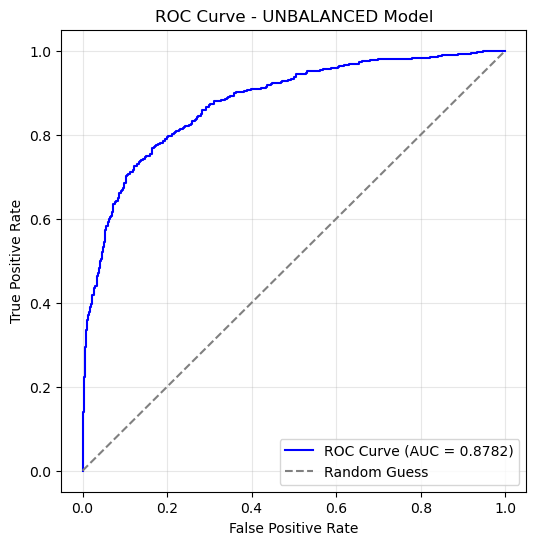

In [19]:
# Output feature importance of final model
feat_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": final_model.get_feature_importance(type='PredictionValuesChange')
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

display(feat_importance_df)

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, final_proba)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {final_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {winner_key.upper()} Model')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

It seems EstimatedSalaryLOG and Is_Balance_0 wasn't useful to the model.

<div style="border: 5px solid gold; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
   
- Consider displaying the ROC curve for a better representation, since it shows us how well the model separates the classes.   
     

- You can also conduct the sanity check using some constant model. It helps us answer the question: "Is this model actually learning something useful or just doing better than guessing?" 
</div>

<div style="border: 5px solid blue; padding: 10px; margin: 5px">
<b> Student's reply </b>

I included the ROC visualization and added a comparison to a baseline model right after the final test evaluation of the winning model.
</div>    

## Conclusion

It was interesting using Optuna for the first time to automate the search. Something I realized is that Optuna uses log loss internally to guide its search. So in a way the F1 optimization is at the mercy of how correlated that log loss implementation is with F1, as that's where the candidates are coming from. In the future I'd like to try out an automated search that would allow me to customize the internal scoring. 

I think a very useful feature would have been "years_with_bank", as in, how long each customer had been with the bank. Could this be in part why NumOfProducts was so important, since the number of products a customer has with the bank is probably correlated with the amount of time the customer has been with the bank?

It's still a bit mysterious to me what parameters I should choose to optimize, since there are so many, as well as the value ranges I should choose for each one. 

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
     
Well done! 
</div>